<a href="https://colab.research.google.com/github/Mo-NJ/Assign1---Supervised-Learning/blob/main/Project2_brain_tumor_detection_v2_2_vgg16_2024_05_15_CatDog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**<center><font size=5>Brain Tumor Detection with VGG-16 Model</font></center>**
***
**last date**: May 6, 2024

**Table of Contents**
- <a href='#intro'>1. Project Overview and Objectives</a>
    - <a href='#dataset'>1.1. Data Set Description</a>
    - <a href='#tumor'>1.2. What is Brain Tumor?</a>
- <a href='#env'>2. Setting up the Environment</a>
- <a href='#import'>3. Data Import and Preprocessing</a>
- <a href='#cnn'>4. CNN Model</a>
    - <a href='#aug'>4.1. Data Augmentation</a>
        - <a href='#demo'>4.1.1. Demo</a>
        - <a href='#apply'>4.1.2. Apply</a>
    - <a href='#build'>4.2. Model Building</a>
    - <a href='#perf'>4.3. Model Performance</a>
- <a href='#concl'>5. Conclusions</a>

# <a id='intro'>1. Project Overview and Objectives</a>

The main purpose of this project was to build a **CNN model** that would classify **if subject has a tumor or not base on MRI scan**. I used the [VGG-16](https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection) model architecture and weights to train the model for this binary problem. I used `accuracy` as a metric to justify the model performance which can be defined as:

$\textrm{Accuracy} = \frac{\textrm{Number of correclty predicted images}}{\textrm{Total number of tested images}} \times 100\%$

Final results look as follows:

| Set | Accuracy |
|:-:|:-:|
| Validation Set* | ~88% |
| Test Set* | ~80% |
<br>
\* *Note: there might be some misunderstanding in terms of set names so I want to describe what do I mean by `test` and `validation` set:*
* *`validation set` - is the set used during the model training to adjust the hyperparameters. *
* *`test set` - is the small set that I don't touch for the whole training process at all. It's been used for final model performance evaluation.*

## <a id='dataset'>1.1. Data Set Description</a>

The image data that was used for this problem is [Brain MRI Images for Brain Tumor Detection](https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection). It conists of MRI scans of two classes:

* `NO` - no tumor, encoded as `0`
* `YES` - tumor, encoded as `1`

Unfortunately, the data set description doesn't hold any information where this MRI scans come from and so on.

## <a id='tumor'>1.2. What is Brain Tumor?</a>

> A brain tumor occurs when abnormal cells form within the brain. There are two main types of tumors: **cancerous (malignant) tumors and benign tumors**. Cancerous tumors can be divided into primary tumors, which start within the brain, and secondary tumors, which have spread from elsewhere, known as brain metastasis tumors. All types of brain tumors may produce symptoms that vary depending on the part of the brain involved. These symptoms may include headaches, seizures, problems with vision, vomiting and mental changes. The headache is classically worse in the morning and goes away with vomiting. Other symptoms may include difficulty walking, speaking or with sensations. As the disease progresses, unconsciousness may occur.
>
> ![](https://upload.wikimedia.org/wikipedia/commons/5/5f/Hirnmetastase_MRT-T1_KM.jpg)
>
> *Brain metastasis in the right cerebral hemisphere from lung cancer, shown on magnetic resonance imaging.*

Source: [Wikipedia](https://en.wikipedia.org/wiki/Brain_tumor)



## Benign vs. Malignat Tumor
![](https://assets.technologynetworks.com/production/dynamic/images/content/364765/benign-vs-malignant-tumors-364765-1280x720.webp?cb=12252466)

Source: [Benign vs. Malignant Tumors] https://www.technologynetworks.com/cancer-research/articles/benign-vs-malignant-tumors-364765)



# <a id='env'>2. Setting up the Environment</a>

In [ ]:
from IPython.display import clear_output
!pip install imutils
clear_output()

# <font color="red">{MO} Update and Look all the libraries used for the Project)

In [ ]:
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
from zipfile import ZipFile
import shutil
import cv2



init_notebook_mode(connected=True)
RANDOM_SEED = 123

Right now all images are in one folder with `yes` and `no` subfolders. I will split the data into `train`, `val` and `test` folders which makes its easier to work for me. The new folder heirarchy will look as follows:

In [ ]:
!apt-get install tree
clear_output()
# create new folders
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO
!tree -d

.
├── sample_data
├── TEST
│   ├── NO
│   └── YES
├── TRAIN
│   ├── NO
│   └── YES
└── VAL
    ├── NO
    └── YES

10 directories


In [ ]:
# Replace 'file_path.zip' with the path to your zip file
zip_file_path = '/content/Project2_db_brain_tumor_image.zip'

# Replace 'extracted_folder' with the name you want for the extracted folder
extracted_folder_path = '/content/extracted_folder'

# Create a ZipFile object
with ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents of the zip file into the specified folder
    zip_ref.extractall(extracted_folder_path)


In [ ]:
IMG_PATH = '/content/extracted_folder/brain_tumor_dataset/'

# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        CLASS_PATH = IMG_PATH + CLASS + '/'  # Adding '/' at the end of the class path
        IMG_NUM = len(os.listdir(CLASS_PATH))
        for (n, FILE_NAME) in enumerate(os.listdir(CLASS_PATH)):
            img = CLASS_PATH + FILE_NAME
            if n < 5:
                shutil.copy(img, '/content/TEST/' + CLASS.upper() + '/' + FILE_NAME)
            elif n < 0.8 * IMG_NUM:
                shutil.copy(img, '/content/TRAIN/' + CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, '/content/VAL/' + CLASS.upper() + '/' + FILE_NAME)


# <a id='import'>3. Data Import and Preprocessing</a>

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(os.path.join(dir_path, path)):
                if not file.startswith('.'):
                    img = cv2.imread(os.path.join(dir_path, path, file))
                    # Resize image to specified dimensions
                    img = cv2.resize(img, img_size)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)


100%|██████████| 2/2 [00:00<00:00,  3.14it/s]


193 images loaded from TRAIN/ directory.


100%|██████████| 2/2 [00:00<00:00, 117.60it/s]


10 images loaded from TEST/ directory.


100%|██████████| 2/2 [00:00<00:00, 13.42it/s]

50 images loaded from VAL/ directory.


In [ ]:
# 193 train images
# 224, 224 are the pixels of images
# each image is 3 dimension
X_train.shape

(193, 224, 224, 3)

In [ ]:
X_test.shape

(10, 224, 224, 3)

In [ ]:
X_val.shape

(50, 224, 224, 3)

Let's take a look at the distribution of classes among sets:

# Convolution Neural Network:
A convolutional neural network (CNN) is a type of artificial neural network used primarily for image recognition and processing, due to its ability to recognize patterns in images.

* [Andrew Ng - Part 1. Computer Vision](https://www.youtube.com/watch?v=ArPaAX_PhIs&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=1)
* [Andrew Ng - Part 2. Edge Detection](https://www.youtube.com/watch?v=XuD4C8vJzEQ&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=2)


# <font color="red">{MO} Update this below graph plot (from Plotly to matplotlib)

In [ ]:
# y = dict()
# y[0] = []
# y[1] = []
# for set_name in (y_train, y_val, y_test):
#     y[0].append(np.sum(set_name == 0))
#     y[1].append(np.sum(set_name == 1))

# trace0 = go.Bar(
#     x=['Train Set', 'Validation Set', 'Test Set'],
#     y=y[0],
#     name='No',
#     marker=dict(color='#33cc33'),
#     opacity=0.7
# )
# trace1 = go.Bar(
#     x=['Train Set', 'Validation Set', 'Test Set'],
#     y=y[1],
#     name='Yes',
#     marker=dict(color='#ff3300'),
#     opacity=0.7
# )
# data = [trace0, trace1]
# layout = go.Layout(
#     title='Count of classes in each set',
#     xaxis={'title': 'Set'},
#     yaxis={'title': 'Count'}
# )
# fig = go.Figure(data, layout)
# iplot(fig)

In [ ]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

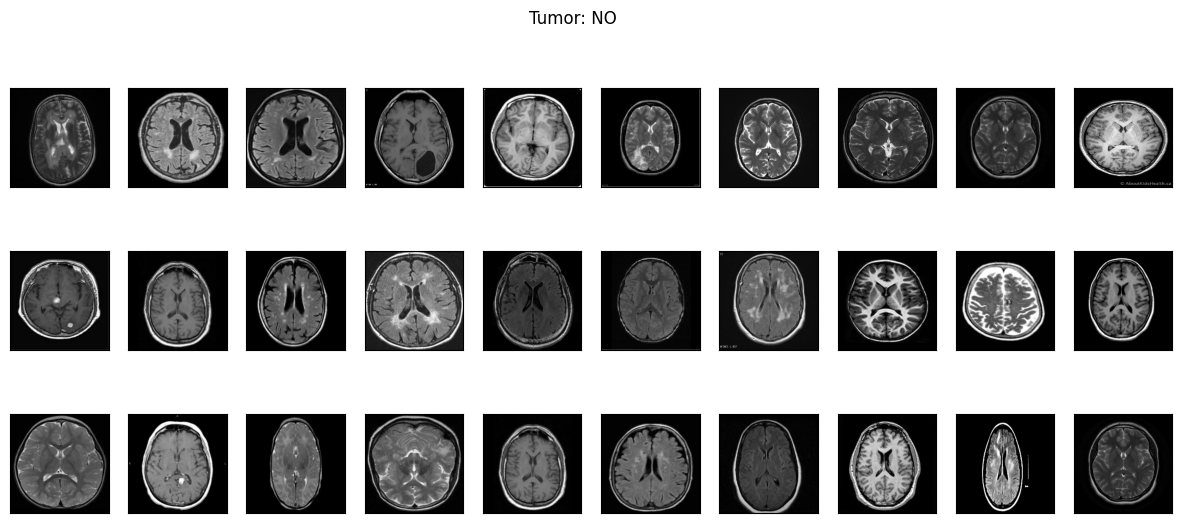

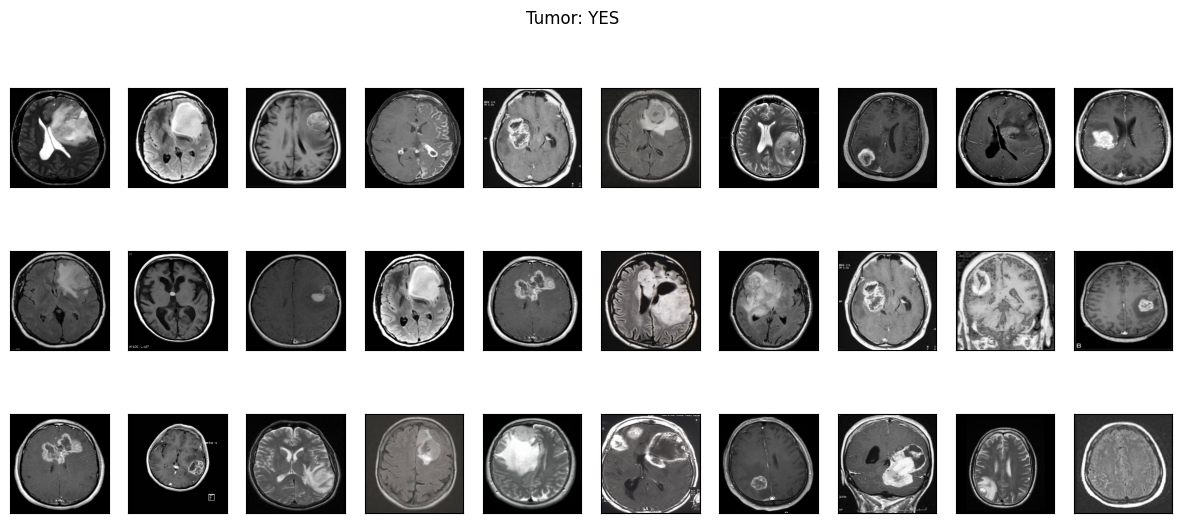

In [ ]:
plot_samples(X_train, y_train, labels, 30)

As you can see, images have different `width` and `height` and diffent size of "black corners". Since the image size for VGG-16 imput layer is `(224,224)` some wide images may look weird after resizing. Histogram of ratio distributions (`ratio = width/height`):

# Histogram Chart
# This graph is showing are there any images which have different width to height ration in training, testing and validation set (lenght or width other than 224x224)

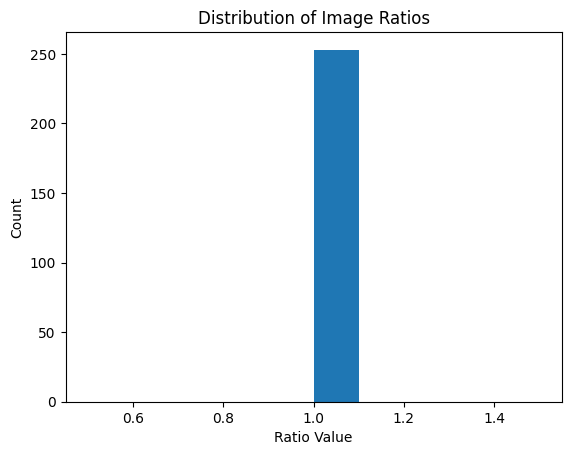

In [ ]:
RATIO_LIST = []
for set in (X_train, X_test, X_val):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])

plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

The first step of "normalization" would be to crop the brain out of the images. I used technique which was perfectly described in [pyimagesearch](https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/) blog and I highly suggest to looks deeper into it.

Let's look at example what this function will do with MRI scans:

In [ ]:
img = cv2.imread('/content/extracted_folder/yes/Y108.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

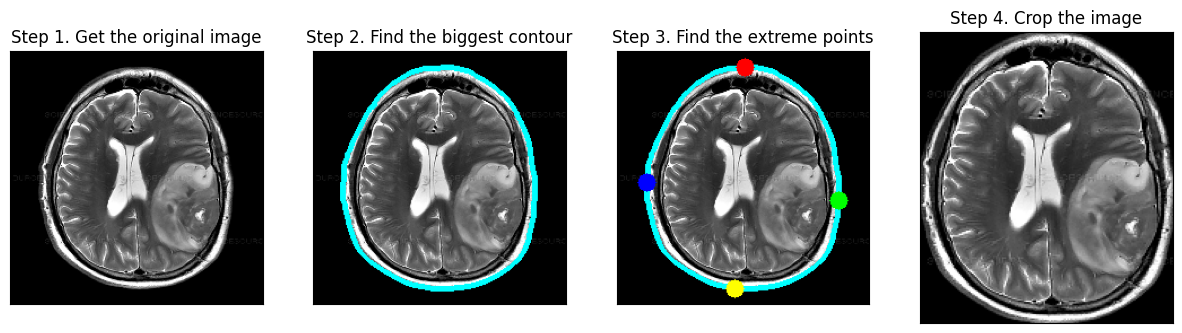

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [ ]:
# Make sure to import imutils for contour operations

def crop_imgs(set_name, add_pixels_value=0, target_size=(100, 100)):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

        # Resize the cropped image to the target size
        new_img_resized = cv2.resize(new_img, target_size)
        set_new.append(new_img_resized)

    return np.array(set_new)

# Example usage:
# Set the target size for cropped images
TARGET_SIZE = (100, 100)

# apply this for each set
X_train_crop = crop_imgs(set_name=X_train, target_size=TARGET_SIZE)
X_val_crop = crop_imgs(set_name=X_val, target_size=TARGET_SIZE)
X_test_crop = crop_imgs(set_name=X_test, target_size=TARGET_SIZE)


In [ ]:
img = cv2.imread('/content/extracted_folder/yes/Y108.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

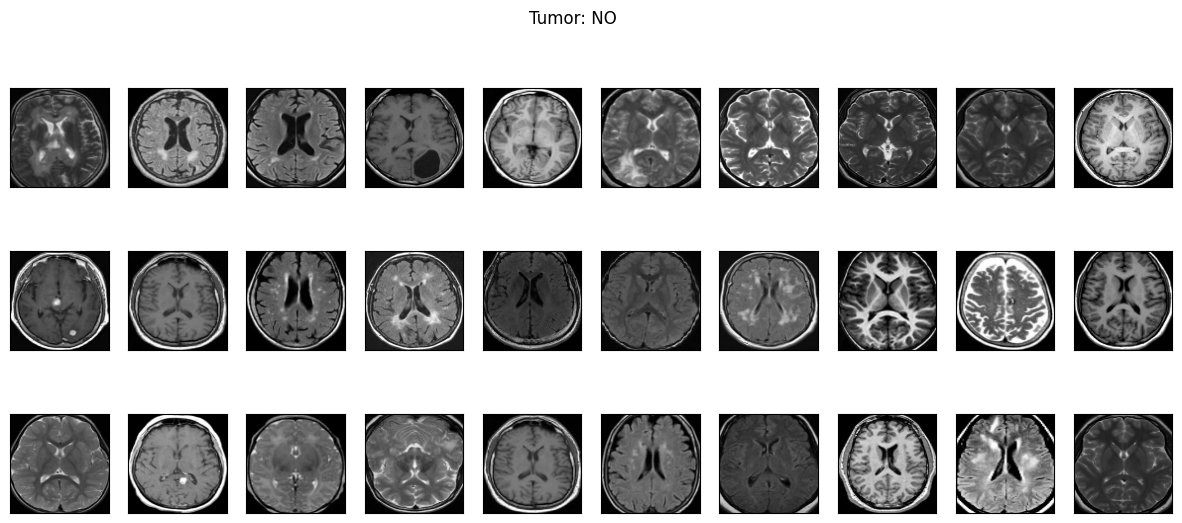

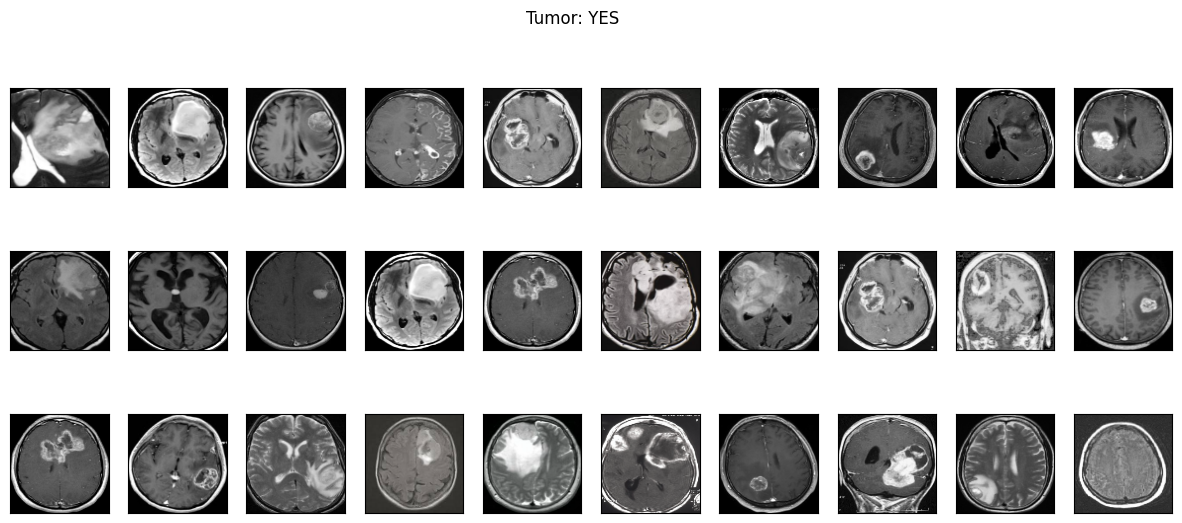

In [ ]:
plot_samples(X_train_crop, y_train, labels, 30)

In [ ]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [ ]:
# saving new images to the folder
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

The next step would be resizing images to `(224,224)` and applying preprocessing needed for VGG-16 model input.

In [ ]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [ ]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

In [ ]:
# plot_samples(X_train_prep, y_train, labels, 30)

# <a id='cnn'>4. CNN Model</a>

I was using [Transfer Learning](https://towardsdatascience.com/keras-transfer-learning-for-beginners-6c9b8b7143e) with VGG-16 architecture and weights as a base model.

## <a id='aug'>4.1. Data Augmentation</a>

Since I had small data set I used the technique called [Data Augmentation](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) which helps to "increase" the size of training set.

### <a id='demo'>4.1.1. Demo</a>

That's the example from one image how does augmentation look like.

In [ ]:
# set the paramters we want to change randomly
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

In [ ]:
os.mkdir('preview')
x = X_train_crop[0]
x = x.reshape((1,) + x.shape)

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break

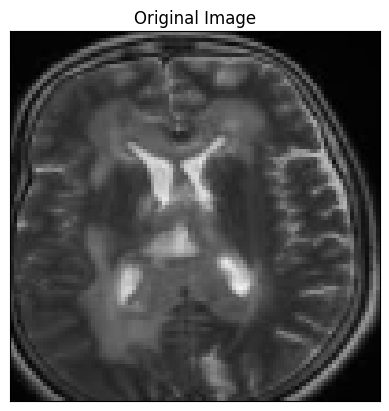

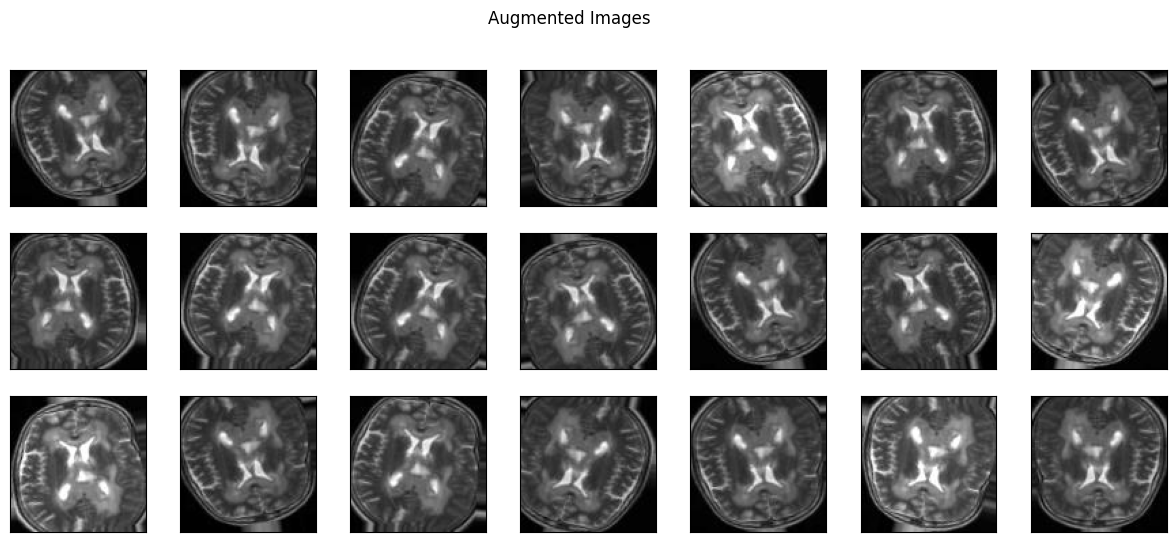

In [ ]:
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augmented Images')
plt.show()

In [ ]:
## remove 'preview' directory from cloud
!rm -rf preview/

### <a id='apply'>4.1.2. Apply</a>

In [ ]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 193 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


## <a id='build'>4.2. Model Building</a>

In [ ]:
# load base model
vgg16_weight_path = '../input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=IMG_SIZE + (3,)
)

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
NUM_CLASSES = 1

model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 14739777 (56.23 MB)
Trainable params: 25089 (98.00 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


# Epoch
An epoch refers to one complete pass of the entire training dataset through the learning algorithm.

ref. [epoch](https://www.youtube.com/watch?v=BvqerWSp1_s&t=50s)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

EPOCHS = 4 # 30
es = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    mode='max',
    patience=6
)

history = model.fit_generator(
    train_generator,
#    steps_per_epoch=50,
    epochs=EPOCHS,
    validation_data=validation_generator,
#    validation_steps=25,
    callbacks=[es]
)

<ipython-input-30-b324870c887e>:10: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/4
7/7 [==============================] - 164s 24s/step - loss: 14.1438 - accuracy: 0.6528 - val_loss: 6.2154 - val_accuracy: 0.6400
Epoch 2/4
7/7 [==============================] - 146s 21s/step - loss: 5.4638 - accuracy: 0.6839 - val_loss: 15.7376 - val_accuracy: 0.6200
Epoch 3/4
7/7 [==============================] - 138s 20s/step - loss: 6.9779 - accuracy: 0.6684 - val_loss: 9.0620 - val_accuracy: 0.6200
Epoch 4/4
7/7 [==============================] - 167s 24s/step - loss: 3.1645 - accuracy: 0.8238 - val_loss: 15.4478 - val_accuracy: 0.6200


## <a id='perf'>4.3. Model Performance</a>

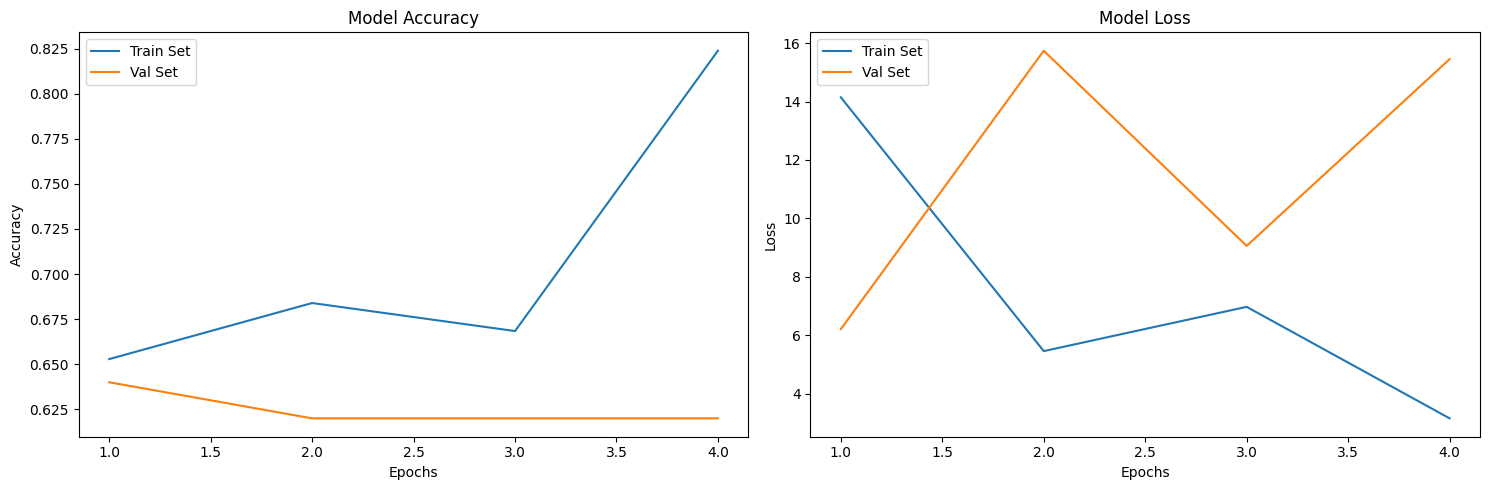

In [ ]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

# <font color="red">{Q} Check this accuracy plot on Val dataset

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

2/2 [==============================] - 34s 10s/step
Val Accuracy = 0.86


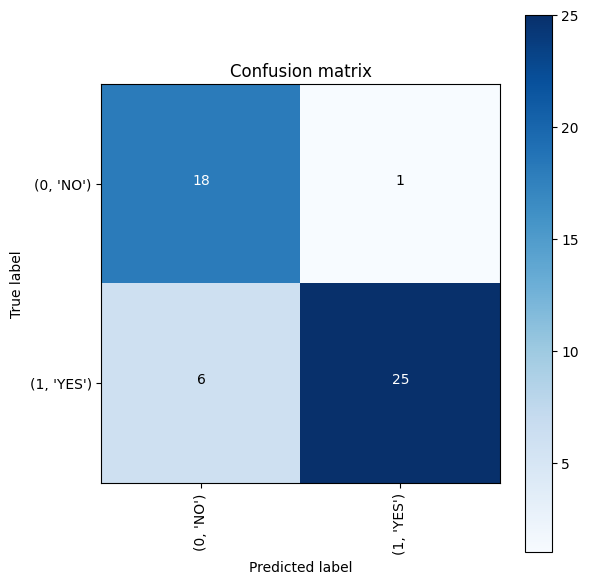

In [ ]:
# validate on val set
predictions = model.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions)
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

# <font color="red">{Q} Check this accuracy plot on test dataset

1/1 [==============================] - 5s 5s/step
Test Accuracy = 0.90


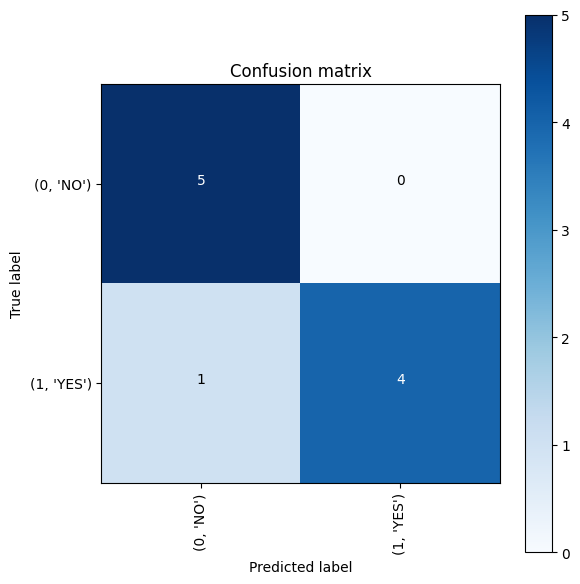

In [ ]:
# validate on test set
predictions = model.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions)
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

Now let's take a look at the images from the `test set` that were misclassified:

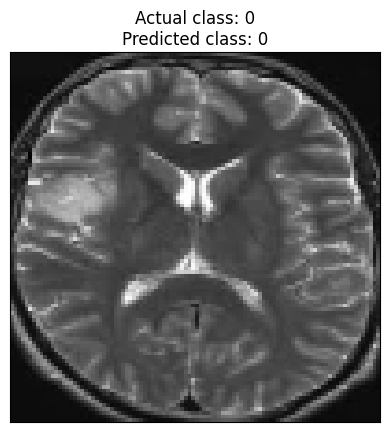

In [ ]:
ind_list = np.argwhere((y_test == predictions) == False)[:, -1]
if ind_list.size == 0:
    print('There are no missclassified images.')
else:
    for i in ind_list:
        plt.figure()
        plt.imshow(X_test_crop[i])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Actual class: {y_val[i]}\nPredicted class: {predictions[i]}')
        plt.show()

First scan looks a bit misleading - what is that light spot in the middle? 🤔 I can clearly see why model classified it as `Tumor`.

# <a id='concl'>5. Conclusions</a>

This project was a combination of CNN model classification problem (to predict wheter the subject has brain tumor or not) & Computer Vision problem (to automate the process of brain cropping from MRI scans). The final accuracy is much higher than 50% baseline (random guess). However, it could be increased by larger number of train images or through model hyperparameters tuning.

In [ ]:
# clean up the space
!rm -rf TRAIN TEST VAL TRAIN_CROP TEST_CROP VAL_CROP
# save the model as keras
model.save('2019-06-07_VGG_model.keras')

# saving the model as h5 file
model.save('2019-06-07_VGG_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



# CNN


* [Ahmad CNN 1](https://youtu.be/zfiSAzpy9NM?si=LdY8nAkzcvglw4zJ)
* [Ahmad CNN 2](https://youtu.be/jztwpsIzEGc?si=bRI9wyvsYYpW0A9M)